Files already downloaded and verified
Files already downloaded and verified
Epoch [1/20], Loss: 1.6698
Epoch [2/20], Loss: 1.4537
Epoch [3/20], Loss: 1.3325
Epoch [4/20], Loss: 1.2389
Epoch [5/20], Loss: 1.1592
Epoch [6/20], Loss: 1.0754
Epoch [7/20], Loss: 1.0034
Epoch [8/20], Loss: 0.9249
Epoch [9/20], Loss: 0.8637
Epoch [10/20], Loss: 0.7966
Epoch [11/20], Loss: 0.7259
Epoch [12/20], Loss: 0.6689
Epoch [13/20], Loss: 0.6154
Epoch [14/20], Loss: 0.5640
Epoch [15/20], Loss: 0.5350
Epoch [16/20], Loss: 0.4892
Epoch [17/20], Loss: 0.4629
Epoch [18/20], Loss: 0.4269
Epoch [19/20], Loss: 0.4112
Epoch [20/20], Loss: 0.3818


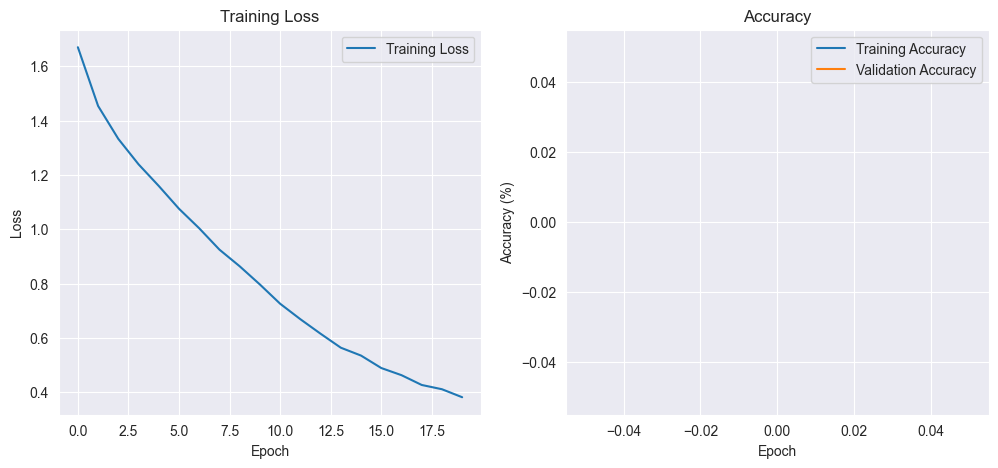

Precision: 0.5248915328847459, Recall: 0.5243, F1 Score: 0.5219904533161861


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 64
learning_rate = 0.001

# CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Splitting train dataset into train and validation sets
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = MLP().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training the model
train_losses = []
train_acc = []
valid_acc = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = calculate_accuracy(train_loader, model)
    validation_accuracy = calculate_accuracy(valid_loader, model)

    train_losses.append(train_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

# Plotting training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Saving the model
torch.save(model.state_dict(), './cifar10_mlp_model.pth')

# Evaluation on the test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}')